**Installing the kaggle package on Google Colab using [ !pip install kaggle ] allows to interact with Kaggle directly within a Colab notebook environment.**


In [ ]:
! pip install kaggle

In [ ]:
!rm -rf /content/dataset

In [ ]:
! mkdir ~/.kaggle

In [ ]:
! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download sriramr/fruits-fresh-and-rotten-for-classification

Dataset URL: https://www.kaggle.com/datasets/sriramr/fruits-fresh-and-rotten-for-classification
License(s): unknown
100% 3.57G/3.58G [00:39<00:00, 178MB/s]
100% 3.58G/3.58G [00:39<00:00, 97.2MB/s]


In [ ]:
!python --version

Python 3.10.12


In [ ]:
import torch
torch.__version__

'2.3.0+cu121'

**Importing the necessary libraries**

In [ ]:
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

In [ ]:
! unzip fruits-fresh-and-rotten-for-classification.zip

Streaming output truncated to the last 5000 lines.
  inflating: dataset/train/rottenapples/rotated_by_60_Screen Shot 2018-06-07 at 3.02.09 PM.png  
  inflating: dataset/train/rottenapples/rotated_by_60_Screen Shot 2018-06-07 at 3.02.18 PM.png  
  inflating: dataset/train/rottenapples/rotated_by_60_Screen Shot 2018-06-07 at 3.02.24 PM.png  
  inflating: dataset/train/rottenapples/rotated_by_60_Screen Shot 2018-06-07 at 3.02.37 PM.png  
  inflating: dataset/train/rottenapples/rotated_by_60_Screen Shot 2018-06-07 at 3.02.51 PM.png  
  inflating: dataset/train/rottenapples/rotated_by_60_Screen Shot 2018-06-07 at 3.03.02 PM.png  
  inflating: dataset/train/rottenapples/rotated_by_60_Screen Shot 2018-06-07 at 3.03.12 PM.png  
  inflating: dataset/train/rottenapples/rotated_by_60_Screen Shot 2018-06-07 at 3.03.21 PM.png  
  inflating: dataset/train/rottenapples/rotated_by_60_Screen Shot 2018-06-07 at 3.03.31 PM.png  
  inflating: dataset/train/rottenapples/rotated_by_60_Screen Shot 2018-06-07

**Dataset (train and test) path in Google Colab**

In [ ]:
train_dir = '/content/dataset/train'
test_dir = '/content/dataset/test'

In [ ]:
import os
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torchvision.transforms import functional as F
import random
import matplotlib.pyplot as plt

train_dir = '/content/dataset/train'
test_dir = '/content/dataset/test'

NUM_WORKERS = os.cpu_count()

class CustomAugmentation:
    def __init__(self):
        self.gaussian_blur = transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5))
        self.additive_gaussian_noise = transforms.Lambda(lambda img: img + torch.randn_like(img) * 0.05)

    def __call__(self, image):
        # Random flip
        if random.random() > 0.5:
            image = F.hflip(image)

        # Random brightness and contrast adjustment
        image = transforms.ColorJitter(brightness=0.1, contrast=0.1)(image)

        # Random rotation
        if random.random() > 0.5:
            angle = random.choice([0, 90, 180, 270])
            image = F.rotate(image, angle)

        # Apply Gaussian blur
        if random.random() > 0.5:
            image = self.gaussian_blur(image)

        return image

class AddGaussianNoise:
    def __call__(self, image):
        return image + torch.randn_like(image) * 0.05

# Defining transform with custom augmentation
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images first
    transforms.Lambda(lambda img: img.convert("RGB")),  # Ensure image is in RGB format
    CustomAugmentation(),           # Apply custom augmentations
    transforms.ToTensor(),          # Convert images to tensors
    AddGaussianNoise()              # Add Gaussian noise to tensors
])

def create_dataloaders(
    train_dir: str,
    test_dir: str,
    transform: transforms.Compose,
    batch_size: int,
    num_workers: int = NUM_WORKERS
):
    # Using ImageFolder to create dataset(s)
    train_data = datasets.ImageFolder(train_dir, transform=transform)
    test_data = datasets.ImageFolder(test_dir, transform=transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor()
    ]))  # No augmentation on test data

    # class names
    class_names = train_data.classes

    # Turning images into data loaders
    train_dataloader = DataLoader(
        train_data,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        pin_memory=True,
    )
    test_dataloader = DataLoader(
        test_data,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=True,
    )

    return train_dataloader, test_dataloader, class_names

In [ ]:
# Set the batch size
BATCH_SIZE = 32

# Create data loaders
train_dataloader, test_dataloader, class_names = create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=transform,
    batch_size=BATCH_SIZE
)

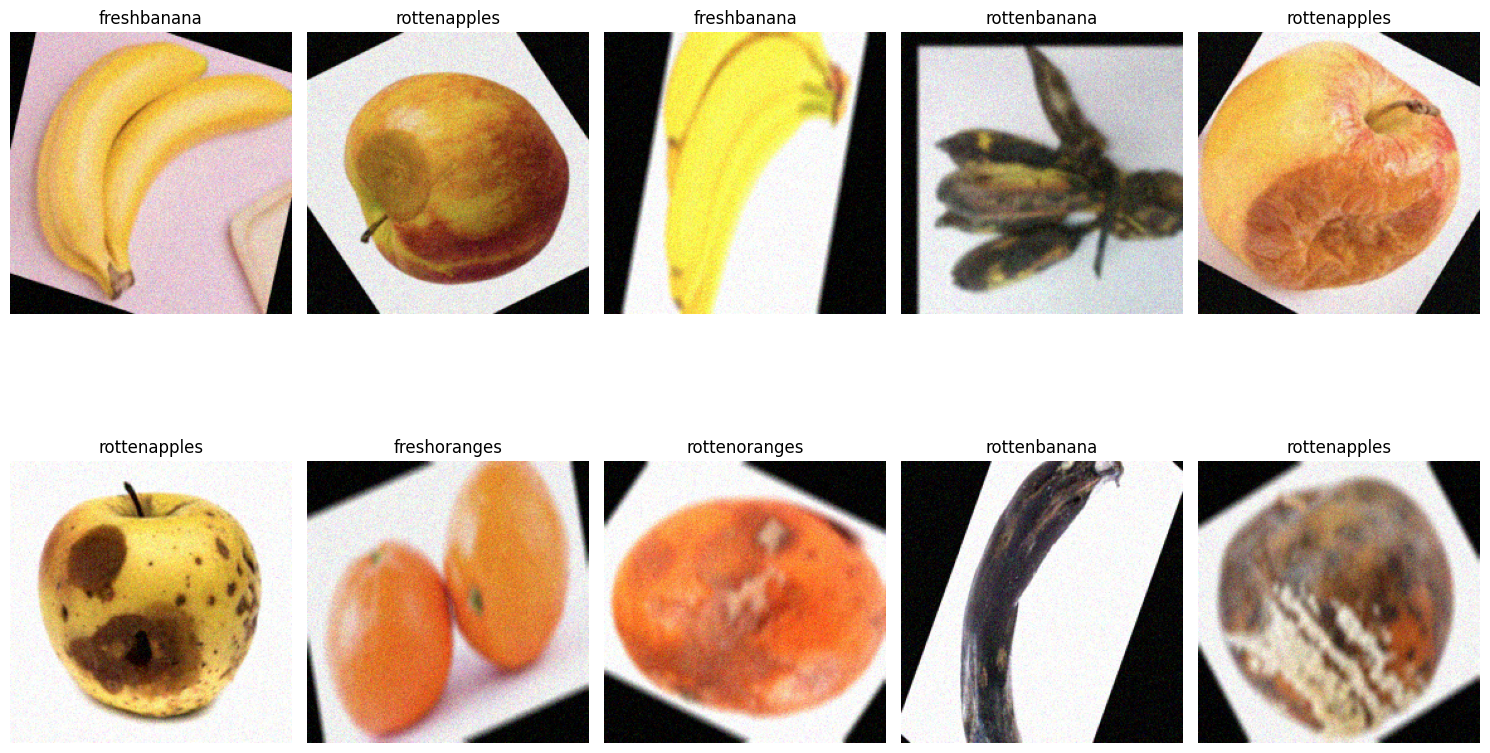

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

dataiter = iter(train_dataloader)

# A batch of data
image_batch, label_batch = next(dataiter)

# Visualization of 10 images from the batch
num_images_to_display = 10

plt.figure(figsize=(15, 10))  # Adjust the figure size as needed

for i in range(num_images_to_display):
    image = image_batch[i]
    label = label_batch[i]

    # Plotting the image
    plt.subplot(2, 5, i + 1)  # 2 rows, 5 columns
    plt.imshow(image.permute(1, 2, 0))  # Rearrange dimensions for matplotlib
    plt.title(class_names[label])
    plt.axis(False)

plt.tight_layout()
plt.show()

**Patch Embedding**

In [ ]:
class PatchEmbedding(nn.Module):

    def __init__(self,
                 in_channels:int=3,
                 patch_size:int=16,
                 embedding_dim:int=768):
        super().__init__()

        self.patcher = nn.Conv2d(in_channels=in_channels,
                                 out_channels=embedding_dim,
                                 kernel_size=patch_size,
                                 stride=patch_size,
                                 padding=0)

        self.flatten = nn.Flatten(start_dim=2, # only flatten the feature map dimensions into a single vector
                                  end_dim=3)

    def forward(self, x):

        image_resolution = x.shape[-1]
        assert image_resolution % patch_size == 0, f"Input image size must be divisble by patch size, image shape: {image_resolution}, patch size: {patch_size}"

        x_patched = self.patcher(x)
        x_flattened = self.flatten(x_patched)

        return x_flattened.permute(0, 2, 1) # adjust so the embedding is on the final dimension [batch_size, P^2•C, N] -> [batch_size, N, P^2•C]

In [ ]:
# Testing on a single image
patch_size =16

# Set seeds
def set_seeds(seed: int=42):

    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)


set_seeds()

patchify = PatchEmbedding(in_channels=3,
                          patch_size=16,
                          embedding_dim=768)

print(f"Input image shape: {image.unsqueeze(0).shape}")
patch_embedded_image = patchify(image.unsqueeze(0))
print(f"Output patch embedding shape: {patch_embedded_image.shape}")

Input image shape: torch.Size([1, 3, 224, 224])
Output patch embedding shape: torch.Size([1, 196, 768])


In [ ]:
print(patch_embedded_image)
print(f"Patch embedding shape: {patch_embedded_image.shape} -> [batch_size, number_of_patches, embedding_dimension]")

tensor([[[-0.0145, -0.0300, -0.0099,  ..., -0.0084, -0.0312, -0.0431],
         [ 0.0146, -0.0200, -0.0475,  ..., -0.0254,  0.0296, -0.0031],
         [-0.0151, -0.0498, -0.0557,  ...,  0.0333, -0.0334, -0.0142],
         ...,
         [-0.0370,  0.0107, -0.0467,  ...,  0.0090,  0.0406, -0.0219],
         [-0.0324, -0.0083,  0.0082,  ..., -0.0168, -0.0415,  0.0237],
         [-0.0224, -0.0206, -0.0975,  ...,  0.0190,  0.0241, -0.0439]]],
       grad_fn=<PermuteBackward0>)
Patch embedding shape: torch.Size([1, 196, 768]) -> [batch_size, number_of_patches, embedding_dimension]


In [ ]:
set_seeds()

patch_size = 16

print(f"Image tensor shape: {image.shape}")
height, width = image.shape[1], image.shape[2]

x = image.unsqueeze(0)
print(f"Input image with batch dimension shape: {x.shape}")

patch_embedding_layer = PatchEmbedding(in_channels=3,
                                       patch_size=patch_size,
                                       embedding_dim=768)

patch_embedding = patch_embedding_layer(x)
print(f"Patching embedding shape: {patch_embedding.shape}")

batch_size = patch_embedding.shape[0]
embedding_dimension = patch_embedding.shape[-1]
class_token = nn.Parameter(torch.ones(batch_size, 1, embedding_dimension),
                           requires_grad=True) # make sure it's learnable
print(f"Class token embedding shape: {class_token.shape}")

patch_embedding_class_token = torch.cat((class_token, patch_embedding), dim=1)
print(f"Patch embedding with class token shape: {patch_embedding_class_token.shape}")

number_of_patches = int((height * width) / patch_size**2)
position_embedding = nn.Parameter(torch.ones(1, number_of_patches+1, embedding_dimension),
                                  requires_grad=True) # make sure it's learnable

patch_and_position_embedding = patch_embedding_class_token + position_embedding
print(f"Patch and position embedding shape: {patch_and_position_embedding.shape}")

print(patch_embedding_class_token)  #1 is added in the beginning of each

Image tensor shape: torch.Size([3, 224, 224])
Input image with batch dimension shape: torch.Size([1, 3, 224, 224])
Patching embedding shape: torch.Size([1, 196, 768])
Class token embedding shape: torch.Size([1, 1, 768])
Patch embedding with class token shape: torch.Size([1, 197, 768])
Patch and position embedding shape: torch.Size([1, 197, 768])
tensor([[[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
         [-0.0145, -0.0300, -0.0099,  ..., -0.0084, -0.0312, -0.0431],
         [ 0.0146, -0.0200, -0.0475,  ..., -0.0254,  0.0296, -0.0031],
         ...,
         [-0.0370,  0.0107, -0.0467,  ...,  0.0090,  0.0406, -0.0219],
         [-0.0324, -0.0083,  0.0082,  ..., -0.0168, -0.0415,  0.0237],
         [-0.0224, -0.0206, -0.0975,  ...,  0.0190,  0.0241, -0.0439]]],
       grad_fn=<CatBackward0>)


In [ ]:
class MultiheadSelfAttentionBlock(nn.Module):

    def __init__(self,
                 embedding_dim:int=768, # Hidden size D from Table 1 for ViT-Base
                 num_heads:int=12, # Heads from Table 1 for ViT-Base
                 attn_dropout:float=0): # doesn't look like the paper uses any dropout in MSABlocks
        super().__init__()

        self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)

        # Creating the Multi-Head Attention (MSA) layer
        self.multihead_attn = nn.MultiheadAttention(embed_dim=embedding_dim,
                                                    num_heads=num_heads,
                                                    dropout=attn_dropout,
                                                    batch_first=True) # does our batch dimension come first?

    # Creating a forward() method to pass the data throguh the layers
    def forward(self, x):
        x = self.layer_norm(x)
        attn_output, _ = self.multihead_attn(query=x, # query embeddings
                                             key=x, # key embeddings
                                             value=x, # value embeddings
                                             need_weights=False)
        return attn_output

In [ ]:
class MLPBlock(nn.Module):
    # Initializing the class with hyperparameters from Table 1 and Table 3
    def __init__(self,
                 embedding_dim:int=768, # Hidden Size D from Table 1 for ViT-Base
                 mlp_size:int=3072, # MLP size from Table 1 for ViT-Base
                 dropout:float=0.1): # Dropout from Table 3 for ViT-Base
        super().__init__()

        self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)

        self.mlp = nn.Sequential(
            nn.Linear(in_features=embedding_dim,
                      out_features=mlp_size),
            nn.GELU(), # "The MLP contains two layers with a GELU non-linearity (section 3.1)."
            nn.Dropout(p=dropout),
            nn.Linear(in_features=mlp_size, # needs to take same in_features as out_features of layer above
                      out_features=embedding_dim), # take back to embedding_dim
            nn.Dropout(p=dropout) # "Dropout, when used, is applied after every dense layer.."
        )

    # Creating a forward() method to pass the data throguh the layers
    def forward(self, x):
        x = self.layer_norm(x)
        x = self.mlp(x)
        return x

In [ ]:
class TransformerEncoderBlock(nn.Module):
    # Initializing the class with hyperparameters from Table 1 and Table 3
    def __init__(self,
                 embedding_dim:int=768, # Hidden size D from Table 1 for ViT-Base
                 num_heads:int=12, # Heads from Table 1 for ViT-Base
                 mlp_size:int=3072, # MLP size from Table 1 for ViT-Base
                 mlp_dropout:float=0.1, # Amount of dropout for dense layers from Table 3 for ViT-Base
                 attn_dropout:float=0): # Amount of dropout for attention layers
        super().__init__()

        # Creating MSA block (equation 2)
        self.msa_block = MultiheadSelfAttentionBlock(embedding_dim=embedding_dim,
                                                     num_heads=num_heads,
                                                     attn_dropout=attn_dropout)

        # Creating MLP block (equation 3)
        self.mlp_block =  MLPBlock(embedding_dim=embedding_dim,
                                   mlp_size=mlp_size,
                                   dropout=mlp_dropout)

    # Creating a forward() method
    def forward(self, x):

        # Creating residual connection for MSA block (add the input to the output)
        x =  self.msa_block(x) + x

        # Creating residual connection for MLP block (add the input to the output)
        x = self.mlp_block(x) + x

        return x

In [ ]:
!pip install torchinfo

In [ ]:
transformer_encoder_block = TransformerEncoderBlock()

from torchinfo import summary
summary(model=transformer_encoder_block,
        input_size=(1, 197, 768), # batch_size, num_patches, embedding_dimension
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
       row_settings=["var_names"])

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
TransformerEncoderBlock (TransformerEncoderBlock)  [1, 197, 768]        [1, 197, 768]        --                   True
├─MultiheadSelfAttentionBlock (msa_block)          [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                      [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─MultiheadAttention (multihead_attn)         --                   [1, 197, 768]        2,362,368            True
├─MLPBlock (mlp_block)                             [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                      [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─Sequential (mlp)                            [1, 197, 768]        [1, 197, 768]        --                   True
│    │    └─Linear (0)                     

In [ ]:
class ViT(nn.Module):
    # Initializing the class with hyperparameters from Table 1 and Table 3
    def __init__(self,
                 img_size:int=224, # Training resolution from Table 3 in ViT paper
                 in_channels:int=3, # Number of channels in input image
                 patch_size:int=16, # Patch size
                 num_transformer_layers:int=12, # Layers from Table 1 for ViT-Base
                 embedding_dim:int=768, # Hidden size D from Table 1 for ViT-Base
                 mlp_size:int=3072, # MLP size from Table 1 for ViT-Base
                 num_heads:int=12, # Heads from Table 1 for ViT-Base
                 attn_dropout:float=0, # Dropout for attention projection
                 mlp_dropout:float=0.1, # Dropout for dense/MLP layers
                 embedding_dropout:float=0.1, # Dropout for patch and position embeddings
                 num_classes:int=1000): # Default for ImageNet but can customize this
        super().__init__() # don't forget the super().__init__()!

        # Making the image size is divisble by the patch size
        assert img_size % patch_size == 0, f"Image size must be divisible by patch size, image size: {img_size}, patch size: {patch_size}."

        # Calculating number of patches (height * width/patch^2)
        self.num_patches = (img_size * img_size) // patch_size**2

        # Creating learnable class embedding
        self.class_embedding = nn.Parameter(data=torch.randn(1, 1, embedding_dim),
                                            requires_grad=True)

        # Creating learnable position embedding
        self.position_embedding = nn.Parameter(data=torch.randn(1, self.num_patches+1, embedding_dim),
                                               requires_grad=True)

        # Creating embedding dropout value
        self.embedding_dropout = nn.Dropout(p=embedding_dropout)

        # Creating patch embedding layer
        self.patch_embedding = PatchEmbedding(in_channels=in_channels,
                                              patch_size=patch_size,
                                              embedding_dim=embedding_dim)

        # Creating Transformer Encoder blocks (we can stack Transformer Encoder blocks using nn.Sequential())
        self.transformer_encoder = nn.Sequential(*[TransformerEncoderBlock(embedding_dim=embedding_dim,
                                                                            num_heads=num_heads,
                                                                            mlp_size=mlp_size,
                                                                            mlp_dropout=mlp_dropout) for _ in range(num_transformer_layers)])

        # Creating classifier head
        self.classifier = nn.Sequential(
            nn.LayerNorm(normalized_shape=embedding_dim),
            nn.Linear(in_features=embedding_dim,
                      out_features=num_classes)
        )

    # Creating a forward() method
    def forward(self, x):

        # Getting batch size
        batch_size = x.shape[0]

        # Creating class token embedding and expand it to match the batch size (equation 1)
        class_token = self.class_embedding.expand(batch_size, -1, -1) # "-1" means to infer the dimension (try this line on its own)

        # Creating patch embedding (equation 1)
        x = self.patch_embedding(x)

        # Concatenation of class embedding and patch embedding (equation 1)
        x = torch.cat((class_token, x), dim=1)

        # Adding position embedding to patch embedding (equation 1)
        x = self.position_embedding + x

        # Running embedding dropout (Appendix B.1)
        x = self.embedding_dropout(x)

        # Passing patch, position and class embedding through transformer encoder layers (equations 2 & 3)
        x = self.transformer_encoder(x)

        # Putting 0 index logit through classifier (equation 4)
        x = self.classifier(x[:, 0]) # run on each sample in a batch at 0 index

        return x

In [ ]:
vit = ViT(num_classes=len(class_names))

In [ ]:
!unzip going_modular.zip

Archive:  going_modular.zip
   creating: going_modular/going_modular/
   creating: going_modular/going_modular/__pycache__/
  inflating: going_modular/going_modular/__pycache__/engine.cpython-39.pyc  
  inflating: going_modular/going_modular/__pycache__/predictions.cpython-39.pyc  
  inflating: going_modular/going_modular/engine.py  
  inflating: going_modular/going_modular/model_builder.py  
  inflating: going_modular/going_modular/predictions.py  
  inflating: going_modular/going_modular/train.py  
  inflating: going_modular/going_modular/utils.py  


In [ ]:
# Use GPU if available, otherwise fall back to CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
epoch = 5
def lr_schedule(epoch):
    initial_lr = 1e-3
    k = 0.2  # Decay rate
    lr = initial_lr * np.exp(-k * epoch)
    print('Learning rate: ', lr)
    return lr

In [ ]:
from going_modular.going_modular import engine

# Setup the optimizer to optimize our ViT model parameters using hyperparameters from the ViT paper
optimizer = torch.optim.Adam(params=vit.parameters(),
                             lr=lr_schedule(epoch), # Base LR from Table 3 for ViT-* ImageNet-1k
                             betas=(0.9, 0.999), # default values but also mentioned in ViT paper section 4.1 (Training & Fine-tuning)
                             weight_decay=0.3) # from the ViT paper section 4.1 (Training & Fine-tuning) and Table 3 for ViT-* ImageNet-1k

# Setup the loss function for multi-class classification
loss_fn = torch.nn.CrossEntropyLoss()

set_seeds()

results = engine.train(model=vit,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=epoch,
                       device=device)

Learning rate:  0.0003678794411714424


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.8569 | train_acc: 0.2082 | test_loss: 1.7911 | test_acc: 0.2210
Epoch: 2 | train_loss: 1.7922 | train_acc: 0.2005 | test_loss: 1.7853 | test_acc: 0.2210
Epoch: 3 | train_loss: 1.7858 | train_acc: 0.2024 | test_loss: 1.7808 | test_acc: 0.2210
Epoch: 4 | train_loss: 1.7852 | train_acc: 0.2058 | test_loss: 1.7895 | test_acc: 0.1949
Epoch: 5 | train_loss: 1.7819 | train_acc: 0.2113 | test_loss: 1.7822 | test_acc: 0.2210


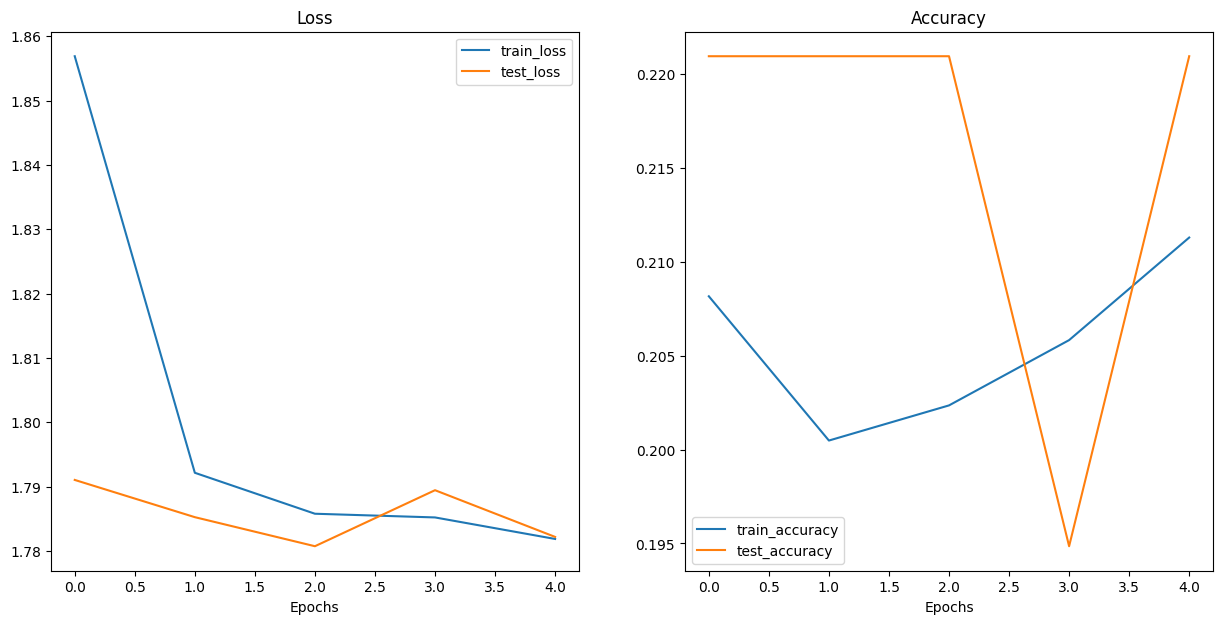

In [ ]:
# To check out our ViT model's loss curves, we can use the plot_loss_curves function from helper_functions.py
from helper_functions import plot_loss_curves

# Plot our ViT model's loss curves
plot_loss_curves(results)